In [2]:
import anndata as ad
import pandas as pd
import numpy as np
import scanpy as sc
import h5py
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')

In [1]:
cells_sp4_path = "/srv/gstore/projects/p37785/RhesusM/segmented_outputs/filtered_feature_cell_matrix.h5"
barcode_mapping_path = "/srv/gstore/projects/p37785/RhesusM/Visium_HD_3prime_Rhesus_Kidney_barcode_mappings.parquet"
tissue_positions002_path = "/srv/gstore/projects/p37785/RhesusM/binned_outputs/square_002um/spatial/tissue_positions.parquet"

In [4]:
# Step 1: Load the feature cell matrix (H5 format)
print("Loading feature cell matrix...")
adata = sc.read_10x_h5(cells_sp4_path)

print(f"Initial AnnData shape: {adata.shape}")
print(f"Cell barcodes (first 5): {list(adata.obs_names[:5])}")

# Step 2: Load barcode mappings
print("\nLoading barcode mappings...")
barcode_mapping = pd.read_parquet(barcode_mapping_path)
print(f"Barcode mapping shape: {barcode_mapping.shape}")
print(f"Barcode mapping columns: {list(barcode_mapping.columns)}")

# Step 3: Load tissue positions for 002um bins
print("\nLoading tissue positions...")
tissue_positions = pd.read_parquet(tissue_positions002_path)
print(f"Tissue positions shape: {tissue_positions.shape}")
print(f"Tissue positions columns: {list(tissue_positions.columns)}")

# Display first few rows to understand the data structure
print("\nFirst 5 rows of barcode mapping:")
print(barcode_mapping.head())
print("\nFirst 5 rows of tissue positions:")
print(tissue_positions.head())

Loading feature cell matrix...
Initial AnnData shape: (137399, 37079)
Cell barcodes (first 5): ['cellid_000000001-1', 'cellid_000000002-1', 'cellid_000000003-1', 'cellid_000000004-1', 'cellid_000000005-1']

Loading barcode mappings...
Initial AnnData shape: (137399, 37079)
Cell barcodes (first 5): ['cellid_000000001-1', 'cellid_000000002-1', 'cellid_000000003-1', 'cellid_000000004-1', 'cellid_000000005-1']

Loading barcode mappings...
Barcode mapping shape: (11222500, 6)
Barcode mapping columns: ['square_002um', 'square_008um', 'square_016um', 'cell_id', 'in_nucleus', 'in_cell']

Loading tissue positions...
Barcode mapping shape: (11222500, 6)
Barcode mapping columns: ['square_002um', 'square_008um', 'square_016um', 'cell_id', 'in_nucleus', 'in_cell']

Loading tissue positions...
Tissue positions shape: (11222500, 6)
Tissue positions columns: ['barcode', 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres']

First 5 rows of barcode mapping:
            squa

In [5]:
# Step 4: Map cell IDs to spatial coordinates
print("Mapping cell IDs to spatial coordinates...")

# Extract cell IDs from AnnData obs_names (remove the -1 suffix)
cell_ids = [obs_name.replace('-1', '') for obs_name in adata.obs_names]
print(f"Sample cell IDs: {cell_ids[:5]}")

# Filter barcode mapping for non-null cell_ids
valid_mappings = barcode_mapping[barcode_mapping['cell_id'].notna()].copy()
print(f"Valid mappings with cell_id: {len(valid_mappings)}")

# Create a mapping from cell_id to 002um barcode (using the first occurrence for speed)
print("Creating cell_id to barcode mapping...")
cell_to_barcode = valid_mappings.groupby('cell_id')['square_002um'].first().to_dict()
print(f"Number of unique cell_ids with barcodes: {len(cell_to_barcode)}")

# Create spatial coordinate arrays
spatial_coords = []
found_coords = 0
missing_coords = 0

print("Finding spatial coordinates for each cell...")
for cell_id in cell_ids:
    if cell_id in cell_to_barcode:
        # Get the corresponding 002um barcode
        barcode_002um = cell_to_barcode[cell_id]
        
        # Find spatial coordinates from tissue positions
        coord_match = tissue_positions[tissue_positions['barcode'] == barcode_002um]
        
        if not coord_match.empty:
            # Use the first match and extract coordinates
            x_coord = coord_match['pxl_col_in_fullres'].iloc[0]
            y_coord = coord_match['pxl_row_in_fullres'].iloc[0]
            spatial_coords.append([x_coord, y_coord])
            found_coords += 1
        else:
            # No spatial coordinate found - use NaN
            spatial_coords.append([np.nan, np.nan])
            missing_coords += 1
    else:
        # Cell ID not found in barcode mapping
        spatial_coords.append([np.nan, np.nan])
        missing_coords += 1

print(f"Found coordinates for {found_coords} cells")
print(f"Missing coordinates for {missing_coords} cells")

# Convert to numpy array and add to AnnData
spatial_coords = np.array(spatial_coords)
adata.obsm['spatial'] = spatial_coords

print(f"Added spatial coordinates to adata.obsm['spatial'] with shape: {adata.obsm['spatial'].shape}")
print(f"Sample coordinates: {adata.obsm['spatial'][:5]}")

Mapping cell IDs to spatial coordinates...
Sample cell IDs: ['cellid_000000001', 'cellid_000000002', 'cellid_000000003', 'cellid_000000004', 'cellid_000000005']
Valid mappings with cell_id: 4199062
Creating cell_id to barcode mapping...
Number of unique cell_ids with barcodes: 137456
Finding spatial coordinates for each cell...
Found coordinates for 0 cells
Missing coordinates for 137399 cells
Added spatial coordinates to adata.obsm['spatial'] with shape: (137399, 2)
Sample coordinates: [[nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]]


In [6]:
# Debug: Check the format of cell IDs in both datasets
print("Debugging cell ID formats...")
print("\nAnnData cell IDs (first 10):")
print(adata.obs_names[:10].tolist())

print("\nBarcode mapping cell IDs (first 10 non-null):")
valid_cell_ids = valid_mappings['cell_id'].dropna().head(10)
print(valid_cell_ids.tolist())

print("\nLet's check if there are any patterns:")
print("Sample barcode mapping cell_id values:")
sample_valid = valid_mappings['cell_id'].dropna().head(20).unique()
print(sample_valid)

Debugging cell ID formats...

AnnData cell IDs (first 10):
['cellid_000000001-1', 'cellid_000000002-1', 'cellid_000000003-1', 'cellid_000000004-1', 'cellid_000000005-1', 'cellid_000000006-1', 'cellid_000000007-1', 'cellid_000000008-1', 'cellid_000000009-1', 'cellid_000000010-1']

Barcode mapping cell IDs (first 10 non-null):
['cellid_000003440-1', 'cellid_000003440-1', 'cellid_000003440-1', 'cellid_000003440-1', 'cellid_000003440-1', 'cellid_000003440-1', 'cellid_000003440-1', 'cellid_000003440-1', 'cellid_000003440-1', 'cellid_000003440-1']

Let's check if there are any patterns:
Sample barcode mapping cell_id values:
['cellid_000003440-1']


In [8]:
# Optimized approach: Use pandas merging for efficiency with runtime feedback
import time

print("Creating optimized spatial coordinate mapping...")
start_time = time.time()

# Step 1: Create a DataFrame from AnnData cell IDs
step_start = time.time()
adata_cells_df = pd.DataFrame({'cell_id': adata.obs_names})
step_time = time.time() - step_start
print(f"✓ AnnData cells DataFrame created: {adata_cells_df.shape} ({step_time:.2f}s)")

# Step 2: Create mapping from cell_id to first barcode (using groupby)
step_start = time.time()
print("Creating cell_id to barcode mapping...")
cell_barcode_mapping = valid_mappings.groupby('cell_id')['square_002um'].first().reset_index()
step_time = time.time() - step_start
print(f"✓ Cell to barcode mapping created: {cell_barcode_mapping.shape} ({step_time:.2f}s)")

# Step 3: Merge AnnData cells with barcode mapping
step_start = time.time()
print("Merging AnnData cells with barcode mapping...")
cells_with_barcodes = adata_cells_df.merge(cell_barcode_mapping, on='cell_id', how='left')
step_time = time.time() - step_start
print(f"✓ Cells merged with barcodes: {cells_with_barcodes.shape} ({step_time:.2f}s)")
print(f"  - Cells with valid barcodes: {cells_with_barcodes['square_002um'].notna().sum()}")

# Step 4: Merge with tissue positions to get spatial coordinates
step_start = time.time()
print("Merging with tissue positions...")
print(f"  - Tissue positions DataFrame size: {tissue_positions.shape[0]:,} rows")
print(f"  - Estimated time for merge: ~{tissue_positions.shape[0] / 1000000 * 2:.1f}s")

cells_with_coords = cells_with_barcodes.merge(
    tissue_positions[['barcode', 'pxl_col_in_fullres', 'pxl_row_in_fullres']], 
    left_on='square_002um', 
    right_on='barcode', 
    how='left'
)
step_time = time.time() - step_start
print(f"✓ Cells merged with coordinates: {cells_with_coords.shape} ({step_time:.2f}s)")
print(f"  - Cells with valid coordinates: {cells_with_coords['pxl_col_in_fullres'].notna().sum()}")

# Step 5: Extract spatial coordinates and add to AnnData
step_start = time.time()
spatial_coords = cells_with_coords[['pxl_col_in_fullres', 'pxl_row_in_fullres']].values
adata.obsm['spatial'] = spatial_coords
step_time = time.time() - step_start
print(f"✓ Spatial coordinates added to AnnData ({step_time:.2f}s)")

total_time = time.time() - start_time
print(f"\n🎉 COMPLETED in {total_time:.2f}s ({total_time/60:.1f} minutes)")
print(f"Added spatial coordinates to adata.obsm['spatial'] with shape: {adata.obsm['spatial'].shape}")
print(f"Sample coordinates:\n{adata.obsm['spatial'][:5]}")

# Summary statistics
non_nan_coords = ~np.isnan(adata.obsm['spatial']).any(axis=1)
print(f"\n📊 Summary:")
print(f"- Total cells: {len(adata.obs_names):,}")
print(f"- Cells with valid coordinates: {non_nan_coords.sum():,}")
print(f"- Cells with missing coordinates: {(~non_nan_coords).sum():,}")
print(f"- Success rate: {non_nan_coords.sum() / len(adata.obs_names) * 100:.2f}%")

Creating optimized spatial coordinate mapping...
✓ AnnData cells DataFrame created: (137399, 1) (0.00s)
Creating cell_id to barcode mapping...
✓ Cell to barcode mapping created: (137456, 2) (0.60s)
Merging AnnData cells with barcode mapping...
✓ Cells merged with barcodes: (137399, 2) (0.47s)
  - Cells with valid barcodes: 137399
Merging with tissue positions...
  - Tissue positions DataFrame size: 11,222,500 rows
  - Estimated time for merge: ~22.4s
✓ Cells merged with coordinates: (137399, 5) (6.64s)
  - Cells with valid coordinates: 137399
✓ Spatial coordinates added to AnnData (0.00s)

🎉 COMPLETED in 7.73s (0.1 minutes)
Added spatial coordinates to adata.obsm['spatial'] with shape: (137399, 2)
Sample coordinates:
[[ 523.90986812 1078.57993125]
 [1645.43014293 1541.09759038]
 [ 450.77551803 1085.27244385]
 [ 343.06727706  857.8247678 ]
 [ 390.29312282 1325.92065286]]

📊 Summary:
- Total cells: 137,399
- Cells with valid coordinates: 137,399
- Cells with missing coordinates: 0
- Succ

In [9]:
# Save the AnnData object with spatial coordinates
output_path = "/srv/GT/analysis/rdegottardi/data/RhesusM_with_spatial_coords.h5ad"

print("Saving AnnData object with spatial coordinates...")
start_time = time.time()
adata.write(output_path)
save_time = time.time() - start_time

print(f"✅ AnnData saved to: {output_path}")
print(f"   Save time: {save_time:.2f}s")
print(f"   File contains: {adata.shape[0]:,} cells x {adata.shape[1]:,} genes")
print(f"   Spatial coordinates: adata.obsm['spatial'] with shape {adata.obsm['spatial'].shape}")

# Quick verification
print(f"\n🔍 Verification:")
print(f"   - Data type: {type(adata.obsm['spatial'])}")
print(f"   - Coordinate range X: [{np.nanmin(adata.obsm['spatial'][:, 0]):.1f}, {np.nanmax(adata.obsm['spatial'][:, 0]):.1f}]")
print(f"   - Coordinate range Y: [{np.nanmin(adata.obsm['spatial'][:, 1]):.1f}, {np.nanmax(adata.obsm['spatial'][:, 1]):.1f}]")

Saving AnnData object with spatial coordinates...
✅ AnnData saved to: /srv/GT/analysis/rdegottardi/data/RhesusM_with_spatial_coords.h5ad
   Save time: 0.64s
   File contains: 137,399 cells x 37,079 genes
   Spatial coordinates: adata.obsm['spatial'] with shape (137399, 2)

🔍 Verification:
   - Data type: <class 'numpy.ndarray'>
   - Coordinate range X: [43.5, 24382.3]
   - Coordinate range Y: [-11.1, 18550.1]
✅ AnnData saved to: /srv/GT/analysis/rdegottardi/data/RhesusM_with_spatial_coords.h5ad
   Save time: 0.64s
   File contains: 137,399 cells x 37,079 genes
   Spatial coordinates: adata.obsm['spatial'] with shape (137399, 2)

🔍 Verification:
   - Data type: <class 'numpy.ndarray'>
   - Coordinate range X: [43.5, 24382.3]
   - Coordinate range Y: [-11.1, 18550.1]


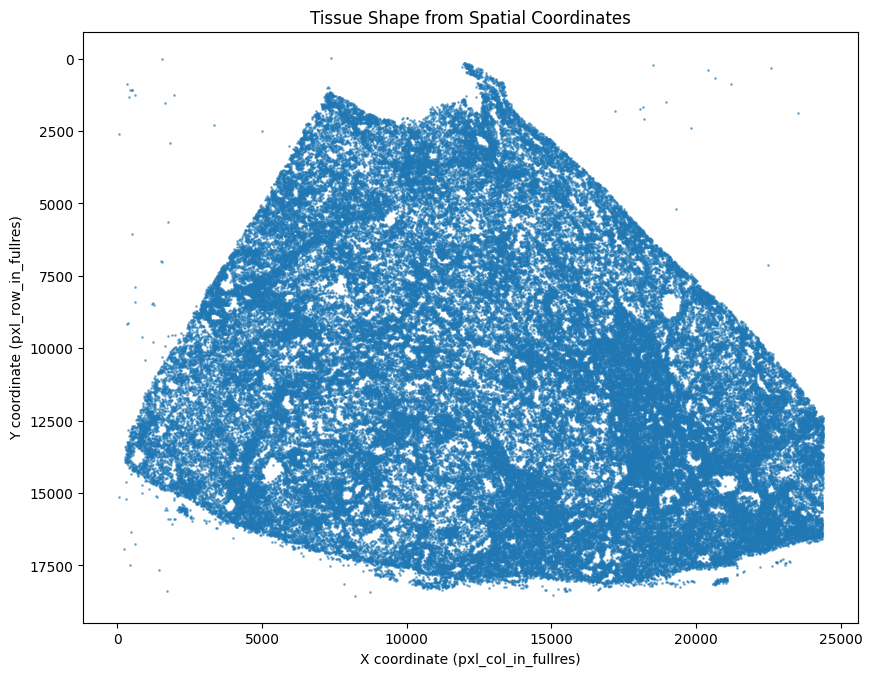

In [10]:
import matplotlib.pyplot as plt

# Extract spatial coordinates from AnnData
coords = adata.obsm['spatial']

plt.figure(figsize=(10, 10))
plt.scatter(coords[:, 0], coords[:, 1], s=1, alpha=0.5)
plt.gca().set_aspect('equal')
plt.xlabel('X coordinate (pxl_col_in_fullres)')
plt.ylabel('Y coordinate (pxl_row_in_fullres)')
plt.title('Tissue Shape from Spatial Coordinates')
plt.gca().invert_yaxis()  # Optional: match image orientation
plt.show()